In [31]:
import numpy as np
import random
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

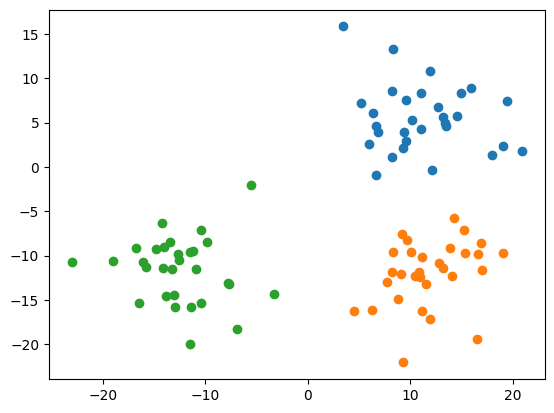

In [32]:
m = 3
k = 3
n = 10 * m * k
points, labels, c = make_blobs(n_samples=n, n_features=m, centers=k, center_box=(-20, 20), cluster_std=4, random_state=10, return_centers=True)
for i in range(k):
    plt.scatter(points[labels==i,0], points[labels==i,-1])

In [33]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def total_distance(points, centroids):
    total = 0
    for point in points:
        min_dist = float('inf')
        for centroid in centroids:
            dist = euclidean_distance(point, centroid)
            if dist < min_dist:
                min_dist = dist
        total += min_dist ** 2
    return total / points.shape[0]

In [34]:
def perturb_centroids(centroids, epsilon):
    return np.round(centroids + epsilon * np.random.randn(*centroids.shape), decimals=5)

def local_beam_search(points, k, beam_width=5, width=5, e=0.1, max_iterations=100):
    centroids_set = np.array([np.random.rand(k, points.shape[1])])
    current_total_distance = total_distance(points, centroids_set[0])
    half_way_checkpoint = []

    for j in range(max_iterations):
        neighbors = np.array([[perturb_centroids(centroids, e) for _ in range(width)] for centroids in centroids_set]).reshape(-1, k, points.shape[1])
        neighbor_distances = [total_distance(points, neighbor) for neighbor in neighbors]
        best_indices = np.argsort(neighbor_distances)[:beam_width]
        centroids_set = np.array([list(neighbors[i]) for i in best_indices])
        current_total_distance = min(neighbor_distances)
        if j == max_iterations // 2:
            half_way_checkpoint = centroids_set[0]

    return centroids_set[0], current_total_distance, half_way_checkpoint

In [35]:
b = 3  # Number of states to consider at each iteration
w = 10 # Number of neighbors to explore at each iteration

# Example
# points = np.array([[1, 1], [1, 2], [2, 1], [2, 2], [6, 6]])
# labels = np.array([0, 0, 0, 0, 1])
# c = np.array([[1.5, 1.5], [6.0, 6.0]])
# m = points.shape[1]
# n = points.shape[0]
# k = 2

centers, total_dist, half_way = local_beam_search(points, k=k, beam_width=b, width=w, max_iterations=200)
print("Centers:\n", centers)
print("Total Distance:", total_dist)

Centers:
 [[ 10.95518 -16.08928   1.6471 ]
 [  7.38644   0.02224  -7.55381]
 [-11.69425   9.40953 -11.74266]]
Total Distance: 65.21936744158214


In [36]:
size = int(n/k)
def assign_points(points, centers):
    assign = {}
    for i in range(n):
        assign[i] = 0
    new_sum = np.array([[0 for l in range(m + 1)] for j in range(k)])
    for j in range(n):
        dists = []
        for l in range(k):
            dists.append((euclidean_distance(points[j], centers[l]), l))
        dists.sort()
        for _, l in dists:
            if new_sum[l][-1] <= size:
                assign[j] = l
                new_sum[l][:-1] = new_sum[l][:-1] + points[j]
                new_sum[l][-1] = new_sum[l][-1] + 1
                break
    return assign

assign = assign_points(points, centers)
assign_half = assign_points(points, half_way)

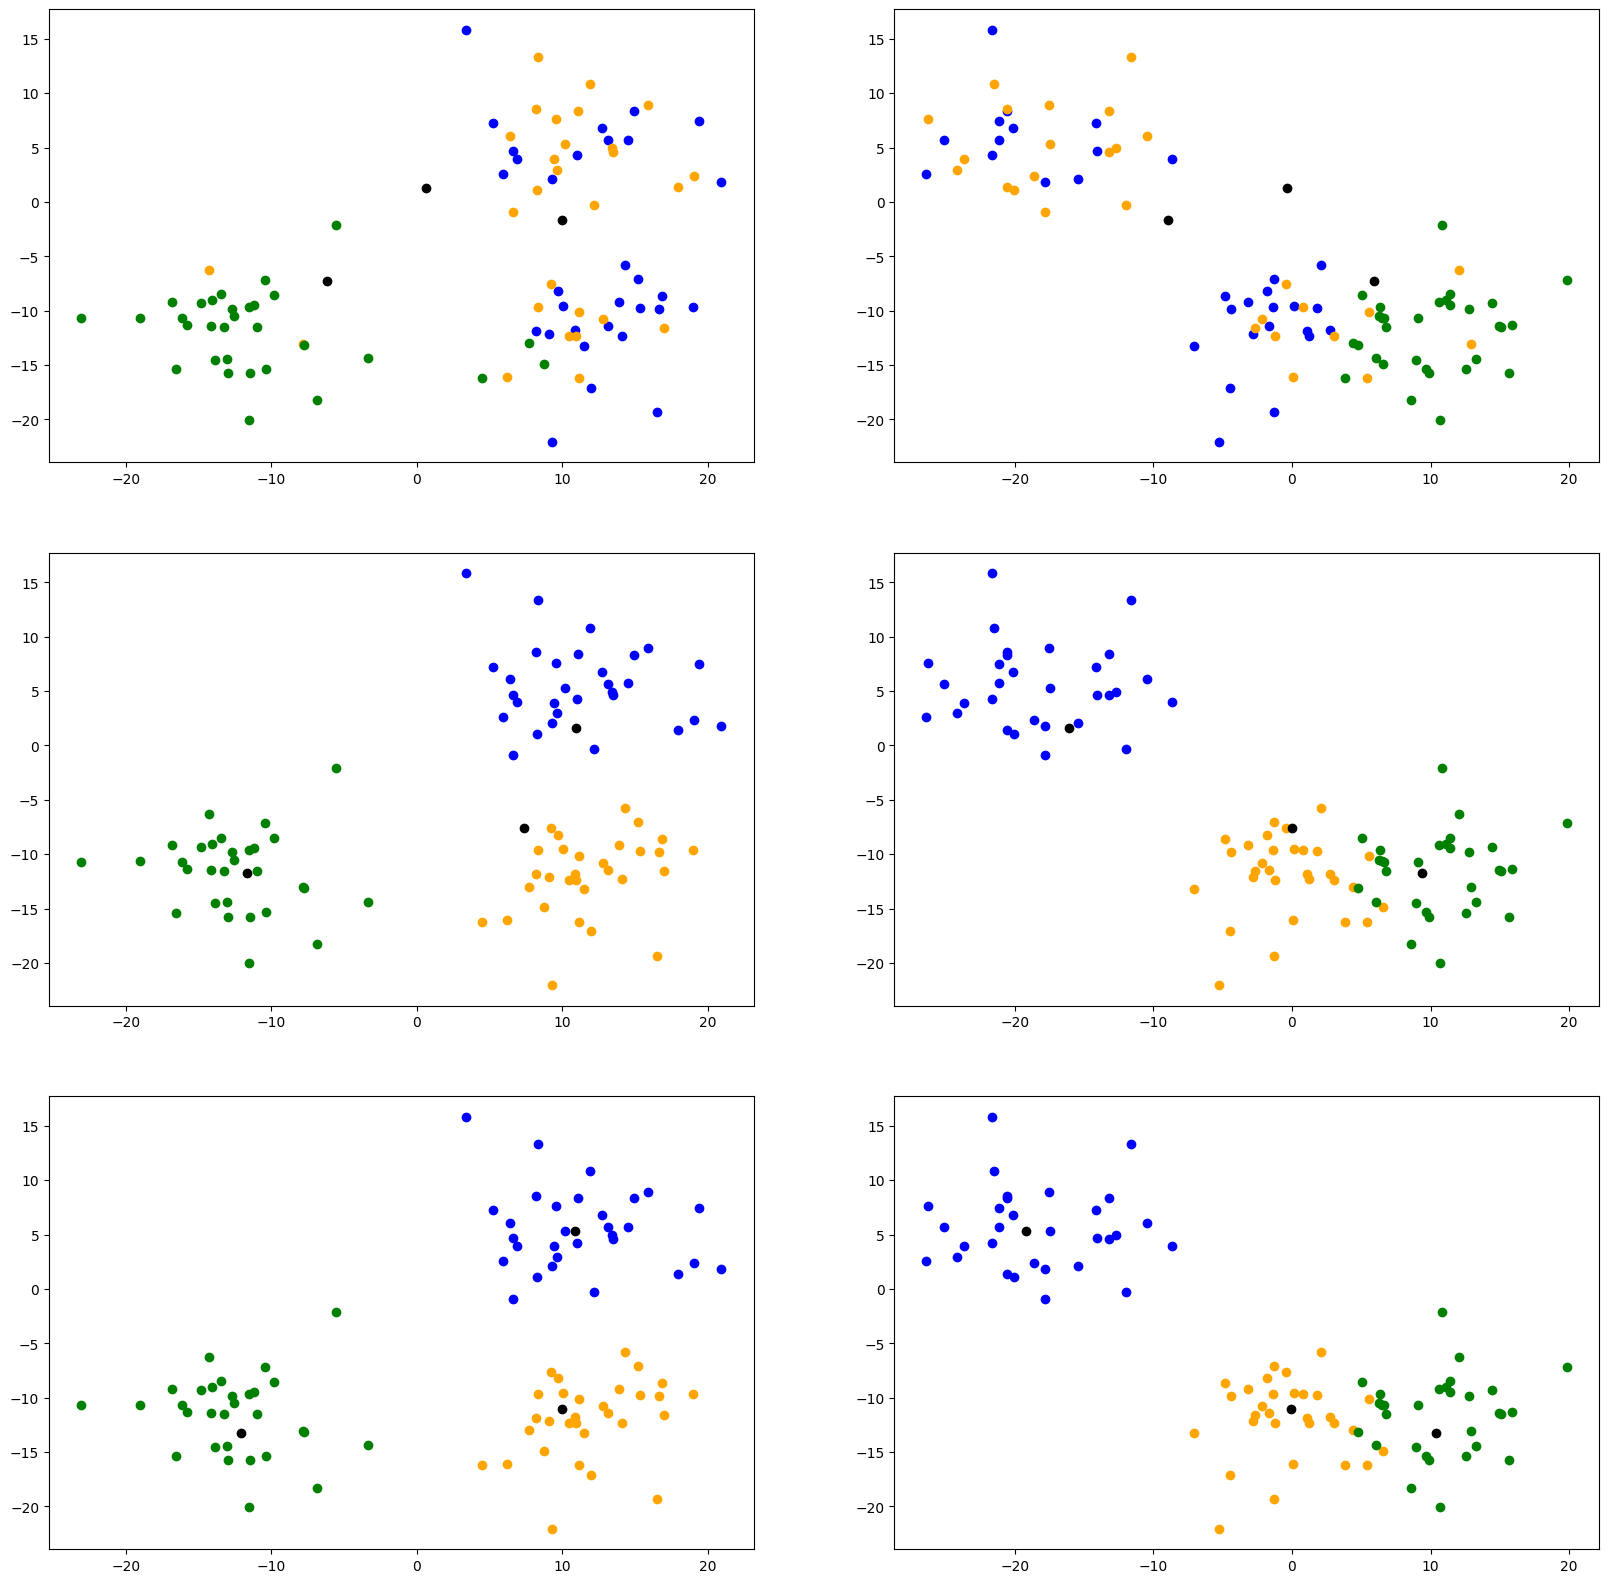

In [37]:
_, (ax1, ax2, ax3) = plt.subplots(3, m - 1, figsize=(20, 40 / (m - 1)))
if m == 2:
    ax1 = [ax1]
    ax2 = [ax2]
    ax3 = [ax3]
colors = ["blue", "orange", "green", "red", "purple", "pink", "yellow", "maroon", "brown"]

for ax in range(m - 1):
    for i in range(k):
        ax3[ax].scatter(points[labels==i,ax], points[labels==i,-1], c=colors[i])
    ax3[ax].scatter(c[:,ax], c[:,-1], c="black")

for ax in range(m - 1):
    for i in range(k):
        points_x = []
        points_y = []
        for j in range(n):
            if assign[j] == i:
                points_x.append(points[j,:-1])
                points_y.append(points[j,-1])
        if len(points_x) > 0:
            ax2[ax].scatter(np.array(points_x)[:,ax], points_y, c=colors[i])
    ax2[ax].scatter(centers[:,ax], centers[:,-1], c="black")

for ax in range(m - 1):
    for i in range(k):
        points_x = []
        points_y = []
        for j in range(n):
            if assign_half[j] == i:
                points_x.append(points[j,:-1])
                points_y.append(points[j,-1])
        if len(points_x) > 0:
            ax1[ax].scatter(np.array(points_x)[:,ax], points_y, c=colors[i])
    ax1[ax].scatter(half_way[:,ax], half_way[:,-1], c="black")